Melhor posição encontrada: x = 0.030303030303030276, y = 1.5454545454545459
Valor máximo encontrado: 8.0717319026177


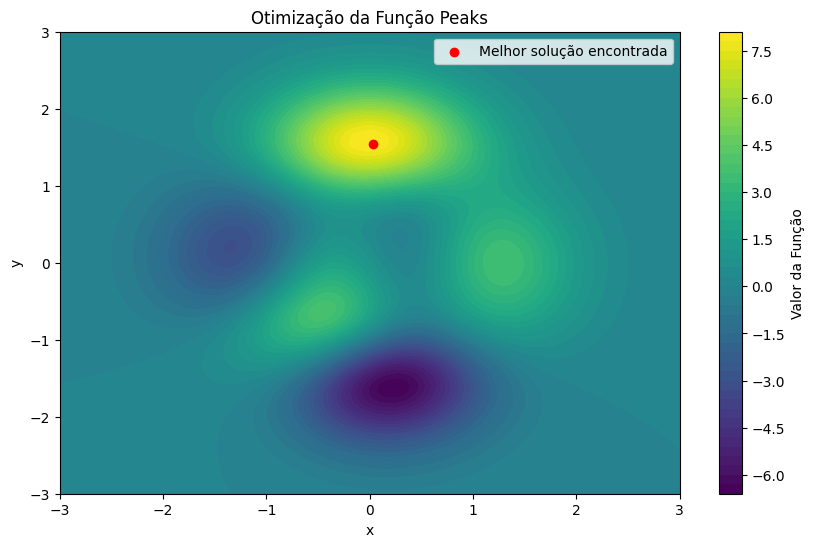

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Definir a função Peaks
def peaks_function(x, y):
    return (3 * (1 - x)**2 * np.exp(-x**2 - (y + 1)**2) 
            - 10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2) 
            - 1/3 * np.exp(-(x + 1)**2 - y**2))

# Classe para Otimização por Colônia de Formigas
class AntColonyPeaks:
    def __init__(self, grid_size, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_constant):
        self.grid_size = grid_size
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_constant = pheromone_constant
        self.pheromone_levels = np.ones((grid_size, grid_size))
        self.best_value = -float('inf')
        self.best_position = None

        # Criar o grid de valores x e y no domínio [-3, 3]
        self.x = np.linspace(-3, 3, grid_size)
        self.y = np.linspace(-3, 3, grid_size)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def run(self):
        for iteration in range(self.num_iterations):
            solutions = []
            solution_values = []

            for ant in range(self.num_ants):
                x_idx, y_idx = self.construct_solution()
                solutions.append((x_idx, y_idx))
                value = peaks_function(self.x[x_idx], self.y[y_idx])
                solution_values.append(value)

                # Atualizar o melhor valor encontrado
                if value > self.best_value:
                    self.best_value = value
                    self.best_position = (self.x[x_idx], self.y[y_idx])

            # Atualizar os níveis de feromônio
            self.update_pheromones(solutions, solution_values)

        return self.best_position, self.best_value

    def construct_solution(self):
        # Escolher aleatoriamente um ponto inicial
        x_idx = np.random.randint(0, self.grid_size)
        y_idx = np.random.randint(0, self.grid_size)

        for step in range(10):  # Número de passos da formiga
            neighbors = self.get_neighbors(x_idx, y_idx)
            probabilities = self.calculate_probabilities(x_idx, y_idx, neighbors)
            next_point = np.random.choice(len(neighbors), p=probabilities)
            x_idx, y_idx = neighbors[next_point]

        return x_idx, y_idx

    def get_neighbors(self, x_idx, y_idx):
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x_idx + dx, y_idx + dy
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append((nx, ny))
        return neighbors

    def calculate_probabilities(self, x_idx, y_idx, neighbors):
        pheromones = np.array([self.pheromone_levels[nx, ny] for nx, ny in neighbors])
        values = np.array([peaks_function(self.x[nx], self.y[ny]) for nx, ny in neighbors])
        
        # Garantir que os valores sejam positivos
        values = values - values.min() + 1e-6  # Shift para evitar valores negativos ou zero

        desirability = pheromones**self.alpha * values**self.beta

        # Tratar diretamente quaisquer valores não numéricos ou negativos
        desirability = np.clip(desirability, a_min=0, a_max=None)

        if desirability.sum() == 0:  # Evitar divisão por zero
            probabilities = np.ones(len(neighbors)) / len(neighbors)
        else:
            probabilities = desirability / desirability.sum()
        
        # Normalizar novamente para evitar erros numéricos
        probabilities = probabilities / probabilities.sum()

        return probabilities

    def update_pheromones(self, solutions, solution_values):
        self.pheromone_levels *= (1 - self.evaporation_rate)
        for (x_idx, y_idx), value in zip(solutions, solution_values):
            self.pheromone_levels[x_idx, y_idx] += self.pheromone_constant * value


# Executar o experimento
if __name__ == "__main__":
    grid_size = 100  # Resolução do grid
    num_ants = 50
    num_iterations = 100
    alpha = 1.0
    beta = 2.0
    evaporation_rate = 0.5
    pheromone_constant = 1.0

    aco = AntColonyPeaks(grid_size, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_constant)
    best_position, best_value = aco.run()

    print(f"Melhor posição encontrada: x = {best_position[0]}, y = {best_position[1]}")
    print(f"Valor máximo encontrado: {best_value}")

    # Visualizar a função Peaks
    Z = peaks_function(aco.X, aco.Y)
    plt.figure(figsize=(10, 6))
    plt.contourf(aco.X, aco.Y, Z, levels=50, cmap="viridis")
    plt.colorbar(label="Valor da Função")
    plt.scatter(*best_position, color="red", label="Melhor solução encontrada")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Otimização da Função Peaks")
    plt.show()
